# Music machine learning - Neural networks

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A [quick introduction](#intro) on the code that we will adress and auxiliary functions
2. A simple implementation for a [single neuron](#single)
3. An implementation of [regression](#implem) using scikit-learn
4. Some [common good practices](#practices) in machine learning

# Introducing neural networks

In this tutorial, we will cover a more advanced classification algorithm through the use of *neural networks*. The tutorial starts by performing a simple **single neuron** discrimination of two random distributions. Then, we will study the typical **XOR problem** by using a more advanced 2-layer **perceptron**. Finally, we generalize the use of neural networks in order to perform classification on a given set of audio files.

We are going to use relatively _low-level_ libraries to perform the first exercises (implementing your own neurons)

In [1]:
import time
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

To simplify your work, we provide a first set of functions that provides simple plotting functionnalities (from the `helper_plot.py` file)

  |**File**|*Explanation*|
  |-------:|:---------|
  |`plot_boundary`|Plots the decision boundary of a single neuron with 2-dimensional inputs|
  |`plot_patterns`|Plots (bi-dimensionnal) input patterns|

In [2]:
from helper_plot import plot_boundary    #plot la droite de séparation (l'hyperplan en dim 2)
from helper_plot import plot_patterns

Remember that a single neuron is only able to learn _linearly separable_ problems. To produce such classes of problems, we provide a script that draw a set of random 2-dimensional points, then choose a random line in this space that will act as the linear frontier between 2 classes (hence defining a linear 2-class problem). The variables that will be used by your code are the following.  

```Matlab
desired       % classes of the patterns 
inputs        % 2 x n final matrix of random input patterns
weights       % 2 x 1 vector of neuron weights
bias          % 1 x 1 vector of bias
```

You can execute the code below to see our simple classification problem. (Note that running the same cell multiple times produces a different starting dataset).

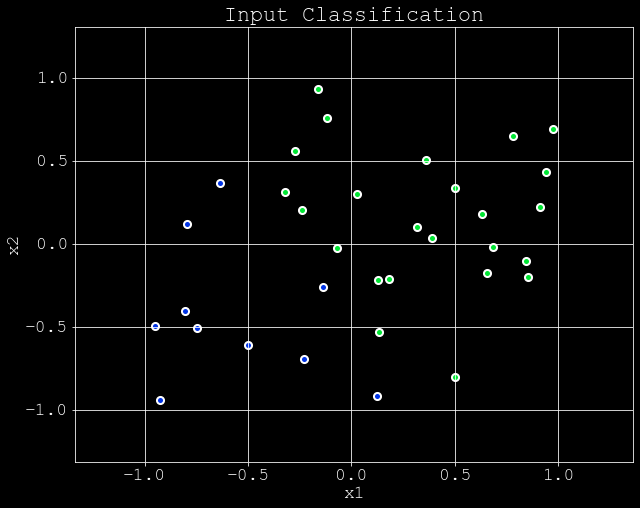

In [3]:
# Number of points to generate
nPats = 30 + np.floor(np.random.rand() * 30);
# Generate 2-dimensional random points
patterns = np.random.rand(2, int(nPats)) * 2 - 1;
# Slope of separating line
slope = np.log(np.random.rand() * 10);
yint = np.random.rand() * 2 - 1;
#print(yint)
# Create the indexes for a two-class problem
desired = (patterns[1,:] - patterns[0,:] * slope - yint > 0) * 1;
#print(desired) #-> vert ou bleu
#print(patterns) #-> coordonnées des points
# Plot the corresponding pattern
fig = plot_patterns(patterns,desired);   

## Single neuron

For the first parts of the tutorial, we will perform the simplest classification model possible in a neural network setting, a single neuron. We briefly recall here that; given an input vector $ \mathbf{x} \in \mathbb{R}^{n} $, a single neuron computes the function  

$$
\begin{equation}
\hat{y}=\phi\left(\sum_{i = 1}^{n}w_{i}.x_{i} + b\right)
\label{eq1}
\end{equation}
$$

with $ \mathbf{w} \in \mathbb{R}^{n} $ a weight vector, $ b $ a bias and $ \phi\left(\cdot\right) $ an *activation function*. Therefore, if we consider the *threshold* activation function ($ \phi_{0}\left(x\right)=1 $ if $ x \geq 0$), a single neuron simply performs an *affine transform* and then a *linear* discrimination of the space. A network will be composed of _layers_ of these neurons, which produce successive computations

<img src="images/02_feedforward_nn.png" align="center"/>

Geometrically, a single neuron computes an hyperplane that separates the space. In order to learn, we have to adjust the weights and know "how much wrong we are". To do so, we consider that we know the desired output $ d $ of a system for a given example $ \mathbf{x} $ (eg. a predicted value for a regression system, a class value for a classification system). Therefore, we define the loss function $ \mathcal{L}_{\mathcal{D}} $ over a whole dataset as

$$
\begin{equation}
\mathcal{L}_{\mathcal{D}}=\sum_{j=1}^{k_{\mathcal{D}}}\left\Vert y_{j}-\hat{y}_{j}\right\Vert ^{2}
\label{eq2}
\end{equation}
$$

In order to know how to change the weights based on the value of the errors, we need to now "how to change it to make it better". Therefore, we should compute the sets of derivatives of the error given each parameter

$$
\begin{equation}
\Delta\bar{\mathbf{w}}=\left(\frac{\delta\mathcal{L}}{\delta w_{1}},\ldots,\frac{\delta\mathcal{L}}{\delta w_{n}}\right)
\label{eq3}
\end{equation}
$$

***

**Exercise**  

  1. Perform the derivatives of the output given a single neuron
  2. Perform the derivatives for the bias as well

***

1. Perform the derivations of the error (???) given a single neuron

En indicant $j$ les différentes entrées, et $i$ les poids :

$$
\begin{align}
    \frac{\delta}{\delta w_i}[L_D] &= \sum_j \frac{\delta}{\delta w_i}(y_j - \hat{y}_j)^2 \\
    &= \sum_j -2(y_j - \hat{y}_j)\frac{\delta \hat{y}_j}{\delta w_i} \\
\end{align}
$$

avec, en notant $x_{j,k}$ la k-ème coordonnées de l'entrée $x_j$: 

$$
\begin{align}
    \frac{\delta \hat{y}_j}{\delta w_i} &= \frac{\delta}{\delta w_i} \phi (\sum_k x_{j,k} w_k + b) \\
    &= \phi'(\sum_k x_{j,k} w_j + b) \frac{\delta}{\delta w_i}(\sum_k x_{j,k} w_k + b) \\
\end{align}
$$

la dernière dérivée étant égale à $x_{j,i}$.

Finalement :

$$\frac{\delta}{\delta w_i}[L_D] = \sum_j -2(y_j - \hat{y}_j)\phi'(\sum_k x_{j,k} w_j + b)x_{j,i} $$


  2. Perform the derivatives for the bias as well
  
 Le calcul est identique sauf que la dernière dérivée vaut 1 :
 
 $$\frac{\delta}{\delta b}[L_D] = \sum_j -2(y_j - \hat{y}_j)\phi'(\sum_k x_{j,k} w_j + b)$$
 
 
 La formule de mise à jour des poids et du biais, pour minimiser l'erreur, est :
 
 $$ \theta_{t+1} = \theta_{t} - \eta \big[grad_{\theta} L_{D}\big]_{\theta_t} $$
 
(le vecteur gradient pointe vers les valeurs croissantes d'où le - dans la formule).
 
 
Pour la suite j'utilise comme fonction d'activation $\phi$ la sigmoïd (je ne comprends pas bien dans l'énoncé si il faut utiliser la fonction seuil ? cela me parait étrange car alors le gradient serait tjrs nul...). J'ai alors :
 
$$ \phi'(\hat{y}) = \hat{y}(1 - \hat{y}) $$

### Training your own neuron

We will start by training a single neuron to learn how to perform this discrimination with a linear problem (so that a single neuron is enough to solve it). 

In [4]:
# Inputs to use
inputs = patterns;
# Initialize the weights
weights = np.random.randn(1, 2);   #2 poids car espace 2D
bias = np.random.randn(1, 1)
# Learning rate
eta = 0.05;
# Weight decay
lambdaW = 0.1

Now you need to update the following code loop to ensure that your neuron learns to separate between the classes 
***

**Exercise**
  1. Update the loop so that it computes the forward propagation error
  2. Update the loop to perform learning (based on back-propagation)
  3. Run the learning procedure, which should produce a result similar to that displayed on the website
  4. Perform multiple re-runs by **tweaking the hyperparameters** (learning rate, weight decay)
  5. What observations can you make on the learning process?
  6. (Optional) Change the input patterns, and confirm your observations.
  6. (Optional) Incorporate the bias in the weights to obtain a **vectorized** code.

***

 0.  weights = -1.887359, 0.444003, -0.579439    loss = 18.910934
 1.  weights = -1.656647, 0.552922, -0.544053    loss = 17.835127
 2.  weights = -1.394533, 0.678328, -0.498763    loss = 16.412071
 3.  weights = -1.105521, 0.817280, -0.441439    loss = 14.582224
 4.  weights = -0.805754, 0.960140, -0.371853    loss = 12.401371
 5.  weights = -0.521667, 1.092504, -0.293151    loss = 10.136635
 6.  weights = -0.276023, 1.204514, -0.210498    loss = 8.169589
 7.  weights = -0.076182, 1.296152, -0.128077    loss = 6.706880
 8.  weights = 0.082213, 1.372464, -0.048142    loss = 5.702771
 9.  weights = 0.207166, 1.438401, 0.028361    loss = 5.020647
10.  weights = 0.306255, 1.497368, 0.101166    loss = 4.544451
11.  weights = 0.385588, 1.551460, 0.170328    loss = 4.197874
12.  weights = 0.449829, 1.601940, 0.236039    loss = 3.934292
13.  weights = 0.502481, 1.649577, 0.298532    loss = 3.725540
14.  weights = 0.546171, 1.694861, 0.358045    loss = 3.554382
15.  weights = 0.582873, 1.73812

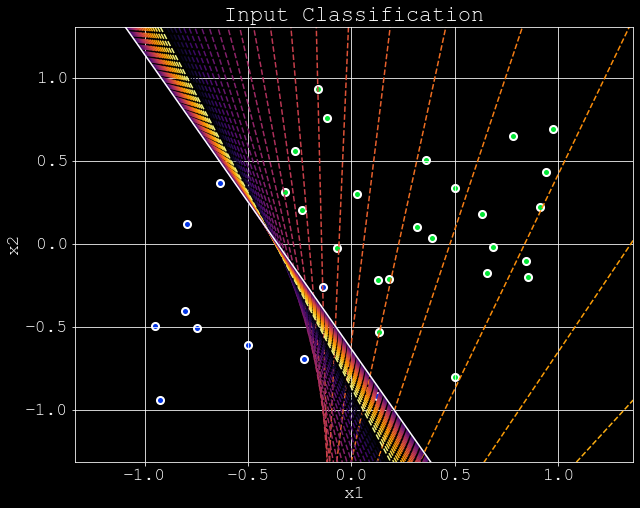

In [5]:
# Plot the corresponding pattern
fig = plot_patterns(patterns,desired);
plt.draw()

def sig(x):   #définition de la fonction sigmoid
    return 1/(1+np.exp(-x))

# Update loop
for i in range(50):   #50 = nb d'itérations dans la descente de gradient
    
    y_hat = sig(np.dot(weights, inputs) + bias) #calcul des y_hat pour toutes les entrées
    
    # y_hat = (weights * inputs + bias) > 0
    
    L = np.sum((desired - y_hat)**2)   #calcul de l'erreur pour tous les y_hat
    
    var =-2*(desired - y_hat)*y_hat*(1-y_hat)   #constante qui revient dans les calculs de gradient
    
    #calcul des gradients par rapport au biais et aux poids
    grad_b = np.sum(var)
    
    grad_w = np.sum(var*inputs, axis=1)
    
    bias -= eta*grad_b   #mise à jour des biais et des poids
    weights -= eta*grad_w
    
    #on peut mettre un break pour s'arrêter lorsque l'erreur est nulle
    
    print('%2d.  weights = %f, %f, %f    loss = %f' % (i, bias[0, 0], weights[0, 0], weights[0, 1], L))
    plot_boundary(np.concatenate((bias, weights), axis=1), i, '--', fig)
    plt.draw()
    time.sleep(0.2)
plot_boundary(np.concatenate((bias, weights), axis=1), i, '-', fig);

In [6]:
y_hat.shape

(1, 34)

Le résultat obtenu est satisfaisant, les deux domaines sont bien séparés. 

Si on augmente $\eta$, on augmente la "vitesse" à laquelle les poids et le biais sont mis à jour, c'est-à-dire la distance de laquelle s'écarte le nouveau poids ou biais de sa position précédente dans la direction du gradient, à chaque itération. Si $\eta$ devient trop grand le minimum peut être "raté" par la descente de gradient dans le sens où les poids "rebondissent" de part et d'autre du minimum sans jamais l'atteindre. (C'est peu le cas ici du fait de mon choix de fonction d'activation sigmoïd dont la dérivée devient très proche de 0 en-dessous de -0.5 et au-dessus de +0.5).

### 2-layer XOR problem

In most cases, classification problems are far from being linear. Therefore, we need more advanced methods to be able to compute non-linear class boundaries. The advantage of neural networks is that the same principle can be applied in a *layer-wise* fashion. This allows to further discriminate the space in sub-regions (as seen in the course). We will try to implement the 2-layer *perceptron* that can provide a solution to the infamous XOR problem. The idea is now to have the output of the first neurons to be connected to a set of other neurons. Therefore, if we take back our previous formulation, we have the same output for the first neuron(s) $\hat{y}$, that we will now term as $y^{(1)}$. Then, we feed these outputs to a second layer of neurons, which gives


$$
\begin{equation}
y^{(2)}=\phi\left(\sum_{i = 1}^{n}w_{i}.y^{(1)}_{i} + b\right)
\label{eq6}
\end{equation}
$$  

Finally, we will rely on the same loss $\mathcal{L_{D}}$ as in the previous exercise, but the outputs used are $y_2$ instead of $y$. As in the previous case, we now need to compute the derivatives of the weights and biases for several layers . However, you should see that some form of generalization might be possible for any number of layer.  


***

**Exercise**  
  1. Perform the derivatives for the last layer specifically
  2. Define a generalized derivative for any previous layer

***

1. Perform the derivatives for the last layer specifically

Pour la dernière couche, on se retrouve dans la même situation que précédemment avec simplement les entrées du neurone qui sont les sorties des neurones de la couche précédente. 

On retrouve les mêmes formules que précédemment en remplaçant le vecteur $x$ par $y^{(1)}$ et le vecteur $\hat{y}$ par $y^{(2)}$. 

2. Define a generalized derivative for any previous layer

On déduit la couche précédente par les formules suivantes :

$$\frac{\delta L}{\delta w^{(1)}} = \frac{\delta L}{\delta w^{(2)}}(1-y^{(1)}w^{(2)}x$$
et
$$\frac{\delta L}{\delta b^{(1)}} = \frac{\delta L}{\delta b^{(2)}}y^{(1)}(1-y^{(1)}w^{(2)}$$

We can construct the prototypical set of XOR values by using the following code (note that this is the most simple case, but still this is typically a problem that cannot be solved by a _linear classifier_

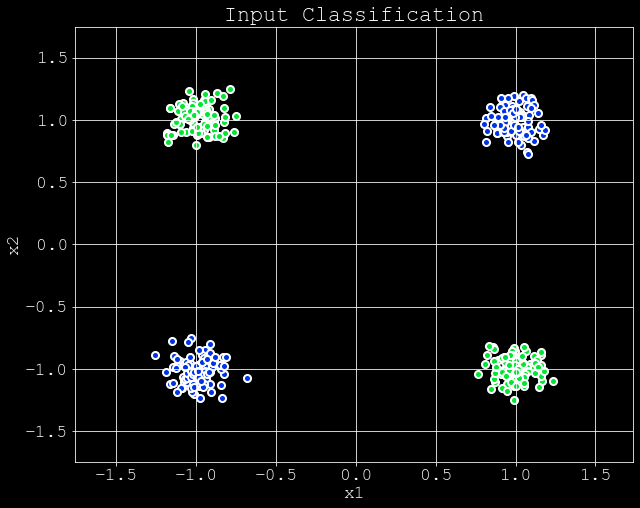

In [7]:
patterns = np.array([[-1, -1],[-1,  1],[1, -1],[1,  1]]).transpose() # Input patterns
desired = np.array([0, 1, 1, 0])  # Corresponding classes
out_patterns = []
out_desired = []  
n_augment = 100
for p in range(4):
    rep_pat = np.repeat(patterns[:, p][:, np.newaxis], n_augment, axis=1)
    out_patterns.append(np.random.randn(2, n_augment) * 0.1 + rep_pat)
    out_desired.append(np.repeat([desired[p]], n_augment))
out_patterns = (np.concatenate(out_patterns, axis=1))
out_desired = (np.concatenate(out_desired))
# Initialize based on their sizes
nInputs = out_patterns.shape[0]
nOutputs = 1
nPat = out_patterns.shape[1]
# First plot the patterns
fig = plot_patterns(out_patterns, out_desired);

The variables that will be used by your code are the following.

```Matlab
patterns          % 2 x n matrix of random points
desired           % classes of the patterns 
inputs1           % 3 x n final matrix of inputs (accounting for bias)
nHiddens          % Number of hidden units
learnRate         % Learning rate parameter
momentum          % Momentum parameter (bonus)
weights1          % 1st layer weights
weights2          % 2nd layer weights
TSS_Limit         % Sum-squared error limit
```

In [8]:
nHiddens = 2     #taille de y1      # Number of hidden units
learnRate = 0.001       # Learning rate parameter
momentum = 0.1         # Momentum parameter
# Overall input patterns
inputs = out_patterns
TSS_Limit = 0.02                                           # Sum-squared error limit
# Learning rate
eta = 0.001

***

**Exercise**  

  1. Update the forward propagation and error computation (compared to desired).
  2. Update the back-propagation part to learn the weights of both layers.
  3. Run the learning, which should produce a result similar to that displayed below.
  4. Perform multiple re-runs of the learning procedure (re-launching with different initializations)
  5. What observations can you make on the learning process?
  6. What happens if you initialize all weights to zeros?
  7. (Optional) Implement the *sparsity* constraint in your neural network.
  7. (Optional) Implement the *weight decay* constraint in your network.
  7. (Optional) Add the *momentum* to the learning procedure.
  
*For optional questions, please look after the first code box for more information*

***

In [9]:
inputs.shape

(2, 400)

Epoch   0:  Error = 159.743117
Epoch   1:  Error = 160.041486
Epoch   2:  Error = 160.337176
Epoch   3:  Error = 160.630202
Epoch   4:  Error = 160.920580
Epoch   5:  Error = 161.208327
Epoch   6:  Error = 161.493458
Epoch   7:  Error = 161.775990
Epoch   8:  Error = 162.055941
Epoch   9:  Error = 162.333327
Epoch  10:  Error = 162.608167
Epoch  11:  Error = 162.880478
Epoch  12:  Error = 163.150280
Epoch  13:  Error = 163.417590
Epoch  14:  Error = 163.682426
Epoch  15:  Error = 163.944809
Epoch  16:  Error = 164.204757
Epoch  17:  Error = 164.462290
Epoch  18:  Error = 164.717426
Epoch  19:  Error = 164.970185
Epoch  20:  Error = 165.220586
Epoch  21:  Error = 165.468650
Epoch  22:  Error = 165.714396
Epoch  23:  Error = 165.957843
Epoch  24:  Error = 166.199011
Epoch  25:  Error = 166.437921
Epoch  26:  Error = 166.674591
Epoch  27:  Error = 166.909043
Epoch  28:  Error = 167.141294
Epoch  29:  Error = 167.371366
Epoch  30:  Error = 167.599277
Epoch  31:  Error = 167.825048
Epoch  3

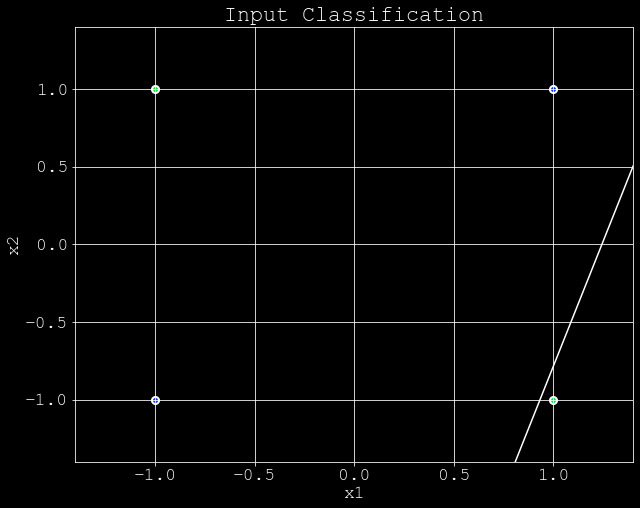

In [10]:
# Weights of first and second layer
weights1 = (np.random.randn(nHiddens, nInputs) - 0.5)      # 1st layer weights ->(2x2) = 2 neurones
weights2 = (np.random.randn(nOutputs, nHiddens) - 0.5)     # 2nd layer weights -> (2x1) = 1 neurone
bias1 = (np.random.randn(nHiddens, 1) - 0.5)               # 1st layer biases -> (2x1)
bias2 = (np.random.randn(nOutputs, 1) - 0.5)               # 2nd layer biases -> (1x1)
# First plot the patterns
fig = plot_patterns(patterns, desired);
# Iterate for a fixed number of iterations
for epoch in range(10000):    #200
  
    # forward propagation
    
    y_1 = sig(np.dot(weights1, inputs) + bias1)  
    y_2 = sig(np.dot(weights2, y_1) + bias2)

    L = np.sum((out_desired - y_2)**2)   #calcul de l'erreur pour tous les y_hat
    
    ## Couche finale
    var2 =(out_desired - y_2)*y_2*(1-y_2)   #constante qui revient dans les calculs de gradient
    
    #calcul des gradients par rapport au biais et aux poids
    #grad_b2 = np.sum(var)
    
    #grad_w2 = np.sum(var*inputs, axis=1)
    
    grad_w2 = np.dot(var2,y_1.T)
    grad_b2 = np.mean(var2,axis=1)[:,np.newaxis]
    
    ## Couche précédente
    
    #grad_w1 = np.dot(weights2[0],grad_w2)*np.dot((1-y_1),inputs.T)
    #grad_b1 = grad_b2*np.dot(np.dot((1-y_1), y_1.T),weights2.T)
    
    #grad_b1 = np.dot(grad_b2,y_1.T)
    #grad_w1 = np.dot(grad_b1,inputs.T)
    
    var1 = np.dot(weights2.T,var2)*y_1*(1-y_1)
    
    grad_w1 = np.dot(var1,inputs.T)
    grad_b1 = np.mean(var1,axis=1)[:,np.newaxis]
    
    
    bias2 -= eta*grad_b2   #mise à jour des biais et des poids
    weights2 -= eta*grad_w2
    
    bias1 -= eta*grad_b1
    weights1 -= eta*grad_w1
    
    TSS = L
        
    print('Epoch %3d:  Error = %f' % (epoch, TSS));
    if TSS < TSS_Limit:
        break
    if (epoch - 1 % 20)==0:
        plot_boundary(np.concatenate((bias2, weights2), axis=1), epoch, '--', fig)

plot_boundary(np.concatenate((bias1, weights1), axis=1), epoch, '-', fig)

**Optional questions**

2. *Weight decay* constraint

As nothing constrains the weights in the network, we can note that usually all weights vector given a multiplicative factor might be equivalent, which can stall the learning (and lead to exploding weights). The *weight decay* allows to regularize the learning by penalizing weights with a too wide amplitude. The idea is to add this constraint as a term to the final loss (which leads to an indirect "pressure" on the learning process. Therefore, the final loss will be defined as

$$
\begin{equation}
\mathcal{L}_{final}=\mathcal{L_D} + \lambda \sum_{l} \sum_{i} \sum_{j} \left( W_{ij}^{l} \right)^{2}
\end{equation}
$$

where the parameter $\lambda$ controls the relative importance of the two terms.

3. *Momentum* in learning

Usually, in complex problems, the gradient can be very noisy and, therefore, the learning might oscillate widely. In order to reduce this problem, we can *smooth* the different gradient updates by retaining the values of the gradient at each iteration and then performing an update based on the latest gradient $\delta_{i}^{t}$ and the gradient at the previous iteration $\delta_{i}^{t-1}$. Therefore, a gradient update is applied as

$$
\begin{equation}
\delta_{final}^{t} = \delta_{i}^{t} + m.\delta_{i}^{t-1}
\end{equation}
$$

with $m$ the momentum parameter, which control the amount of gradient smoothing.

## 3-layer audio classification

Finally, we will attack a complete audio classification problem and try to perform neural network learning on a set of audio files. The data structure will be the same as the one used for parts 1 and 2. As discussed during the courses, even though a 2-layer neural network can provide non-linear boundaries, it can not perform "holes" inside those regions. In order to obtain an improved classification, we will now rely on a 3-layer neural network. The modification to the code of section 3.2 should be minimal, as the back-propagation will be similar for the new layer as one of the two others. We do not develop the math here as it is simply a re-application of the previous rules with an additional layer (which derivatives you should have generalized in the previous exercise).  

However, up until now, we only performed *binary classification* problems, but this time we need to obtain a decision rule for multiple classes. Therefore, we cannot rely on simply computing the distance between desired patterns and the obtained binary value. The idea here is to rely on the *softmax regression*, by considering classes as a vector of probabilities. The desired answers will therefore be considered as a set of *probabilities*, where the desired class is $1$ and the others are $0$ (called *one-hot* representation). Then, the cost function will rely on the softmax formulation

$$
\begin{equation}
\mathcal{L_D}(\theta) = - \frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{j=1}^{k} 1\left\{y^{(i)} = j\right\} log \frac{e^{\theta_{j}^{T} x^{(i)}}}{\sum_{l=1}^{k} e^{ \theta_{l}^{T} x^{(i)} }}  \right]
\end{equation}
$$

Therefore, we compute the output of the softmax by taking 

$$
\begin{equation}
p(y^{(i)} = j | x^{(i)}; \theta) = \frac{e^{\theta_{j}^{T} x^{(i)}}}{\sum_{l=1}^{k} e^{ \theta_{l}^{T} x^{(i)}} }
\end{equation}
$$

By taking derivatives, we can show that the gradient of the softmax layer is

$$
\begin{equation}
\nabla_{\theta_{j}} \mathcal{L_D}(\theta) = - \frac{1}{m} \sum_{i=1}^{m}{ \left[ x^{(i)} \left( 1\{ y^{(i)} = j\}  - p(y^{(i)} = j \mid x^{(i)}, \theta) \right) \right]}
\end{equation}
$$

### Sweet activation functions

As discussed in the course, the interest of stacking layers is that there is an _activation function_, which allows non-linear interactions between the dimensions (and avoids to only compute a single huge affine transform). Although the `sigmoid` function has been historically the most used, there has been some large developments since. Notably the `ReLU` (Rectified Linear Unit) is one of the major difference in modern networks (we will see more about that in a later course)

In [11]:
# Function for computing the Sigmoid activation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(a):
    return a * (1.0 - a)
# Function for computing the ReLU activation
def relu(x):
    return np.maximum(0, x)
def drelu(x):
    return 1 / (1 + np.exp(-x))
# Function for computing the Tanh activation
def tanh(x):
    return np.tanh(x);
def dtanh(x): 
    return np.cosh(x) ^ -2

Here, we plot some simple examples of what these activation functions look like. You can try to rely on these functions in your previous training code and witness the differences in training.


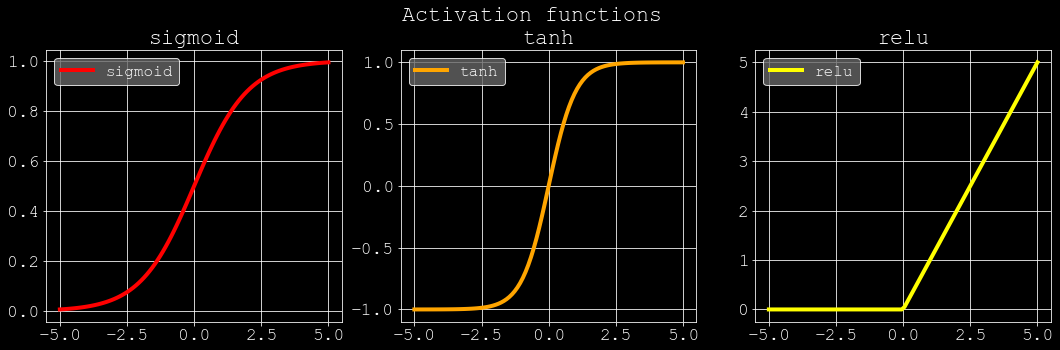

In [12]:
from helper_plot import prep_plots, finalize_plots
funcs = [('sigmoid',sigmoid,'red'), ('tanh',tanh,'orange'), ('relu',relu,'yellow')]
axes = prep_plots([funcs[0][0], funcs[1][0], funcs[2][0]], fig_size=(18,5), fig_num=1)
x_plot = np.linspace(-5,5,100)
np.maximum(0, x_plot)
for f in range(3):
    axes[f].plot(x_plot, funcs[f][1](x_plot), color=funcs[f][2], linewidth=4, label=funcs[f][0])
finalize_plots(axes, fig_title="Activation functions")

## Coding the whole network from scratch

You should now have all the tools necessary to apply neural networks from scratch to a more complex problem. In the following exercise, we simply removed any guideline code, and you need to code all the procedure for training a NN and **apply it to audio data**. You will use the spectral features discussed in the previous exercise as an input.

***

**Exercise**

  1. Based on the previous neural network, upgrade the code to a 3-layer neural network
  2. Implement the *softmax regression* on top of your 3-layer network
  3. Use the provided code to perform classification on a pre-defined set of features
  4. As previously, change the set of features to assess their different accuracies
  5. Evaluate the neural network accuracy for all features combinations
  6. What happens if the learning rate is too large ? What is this phenomenon ?
  7. (Optional) Perform a more advanced visualization of the learning process.
  
***

In [13]:
# Iterate for a fixed number of iterations

from helper_data import import_dataset
from helper_data import compute_transforms
# 0.1 - Import the classification dataset
class_path = 'data/classification';
data_struct = import_dataset(class_path, 'classification');

data_struct = compute_transforms(data_struct);

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'data/classification'

In [ ]:
from helper_data import compute_features
data_struct = compute_features(data_struct);


#nInputs = len(inputs)

#weights1 = (np.random.randn(3, nInputs) - 0.5)


#weights2 = np.random.randn()

In [ ]:
for epoch in range(500):
    
    
    print('Epoch %3d:  Error = %f\n' % epoch, TSS);
    if TSS < TSS_Limit:
        break
plo_boundary(np.concatenate(bias1, weights1), epoch, '-');

## Using Pytorch to enjoy life

Up to now, we have been writing every operations by ourselves (in order to better understand the mathematics behind NN). However, there exists of course some simplifying libraries that provide large simplifications to this question.

One of the most powerful and complete library of this sort is `Pytorch`, which has been developed for several years (even prior to the recent boom of deep learning). `Pytorch` provides a large set of pre-coded layers, but also **computational graphs** and **autograd**, which are very powerful paradigms allowing to define complex operators and automatically taking derivatives.

### Defining our network

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning. In `PyTorch`, the `nn` package provides higher-level abstractions over raw computational graphs that are useful for building neural networks. The `nn` package defines a set of `Modules`, which are roughly equivalent to neural network layers. A `Module` receives input `Tensors` and computes output `Tensors`, but may also hold internal state such as `Tensors` containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

In the following example, we use the `nn` package to show how easy it is to instantiate our previous three-layers network

In [ ]:
import torch
# Define the input dimensions
in_size = 1000
# Number of neurons in a layer
hidden_size = 100
# Output (target) dimension
output_size = 10
# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(in_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, output_size),
    torch.nn.Softmax(dim=1)
)

### Optimizing the network

Up to this point we have updated the weights of our models by manually performing the gradient descent algorithm (changing the parameters vectors). Although this is not a huge burden for simple optimization algorithms like stochastic gradient descent, in practice we often train neural networks using more sophisticated optimizers like AdaGrad, RMSProp or Adam (that we will see later in this course)

The `optim` package in PyTorch abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms, and greatly simplfies the training loop associated with training a neural network.

For the sake of presentation we will use random inputs $\mathbf{x}$ that should be matched with random outputs $\mathbf{y}$

In [ ]:
batch_size = 64
# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

In the following example we optimize the model using the Adam algorithm provided by the `optim` package, based on a `MSE` loss.

In [ ]:
# Learning rate
learning_rate = 1e-4
# Loss function that we will use
loss_fn = torch.nn.MSELoss(reduction='sum')
# Optimizer to fit the weights of the network
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    # Compute the loss.
    loss = loss_fn(y_pred, y)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()

## Using Pytorch to classify audio

Now that we know the main components of `Pytorch` to define and optimize networks, your assignement is to define a complete classification problem from audio data, by relying on this toolbox

***

**Exercise**

  1. Use `Pytorch` to define a model for audio classification
  2. Import the audio features dataset and check that your model produces an output
  3. Write the optimization loop (think carefully about the _loss function_
  4. As previously, change the set of features to assess their different accuracies
  5. Think of how you could use more complex features (time series, audio, STFT) to classify your data
  
***

In [ ]:

######################
# YOUR CODE GOES HERE
######################
    